# Introduction to Machine Learning with scikit-learn
## Lab 4: Clustering
The goal of this lab session is to discover a few clustering algorithms from scikit-learn. As for the classification and clustering labs, we will start with generated data to have a more visual idea of the results.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### $k$-means algorithm
#### Recap from the lecture
Let us start with the $k$-means algorithm. Remind that this algorithm takes the number of classes $k$ as a parameter and, given a set of $n$ points $X = \left\{ x_1, x_2, \dots, x_n \right\}$, aims at finding a partition $S = \left\{ S_1, S_2, \dots, S_k\right\}$ of $X$ minimizing the within-cluster sum of squares, that is:
$$\min_S \sum_{i = 1}^{k} \sum_{x \in S_i} \left\lVert x - \mu_i\right\rVert_2^2$$
where 
$$\mu_i = \dfrac{1}{|S_i|} \sum_{x \in S_i} x$$
is the centroid (mean) of points in $S_i$ and $|S_i|$ is the cardinality (number of elements) of $S_i$. Recall that $\mu_i$ is not necessarily in $X$.

As we saw during lecture 4, one of the ways to find the optimal partition $S$ is to iteratively apply following two steps:
- Define the **Voronoi diagram** generated by the $\mu_i$s:
$$S_i^t = \left\{ x_p \mid \left\lVert x - \mu_i^t\right\rVert \leq \left\lVert x - \mu_j^t\right\rVert, 1 \leq j \leq k \right\}$$
- Update the centroid:
$$\mu_i^{t+1} = \text{centroid}(S_i^t) = \dfrac{1}{|S_i^t|} \sum_{x \in S_i^t} x$$

for all $i \in \left\{ 1, \dots, k\right\}$. 

#### Generating the dataset
As we usually do, we will generate a dataset. This time, we will do it with the `sklearn.datasets.make_blobs` function which generates Gaussian blobs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

We will use 3 parameters of this function: The number of samples `n_samples` we want to generate, the number of blobs `centers` we want to generate as well as a seed `random_state` as with most randomized functions. A more detailed description can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

In the following, we will generate 3 distinct classes of 500 points and display them.

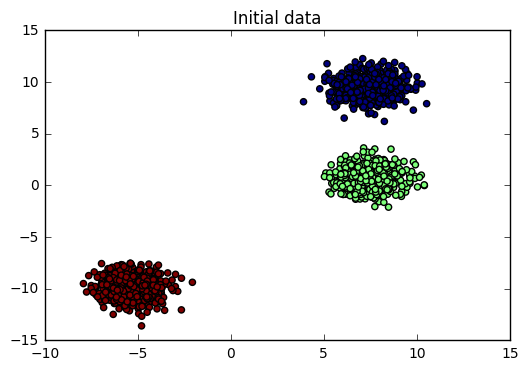

In [3]:
# Initial data
n_samples = 1500
random_state = 8
X, y = make_blobs(n_samples=n_samples, centers=3, random_state=random_state)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Initial data")

#### $k$-means clustering with sklearn
Now we have a dataset, we can apply the $k$-means algorithm to it with various numbers of classes and see what the results look like. The function which performs this task is `sklearn.cluster.KMeans` and takes a `n_clusters` parameter which is the value of $k$. A detailed documentation of the algorithm can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
As we generated 3 classes, we intuitively expect best results with $k = 3$.
Let's start with $k = 2$ to see how the algorithm splits the 3 blobs into 2 classes.
Note that as we are doing clustering, we don't give `y` to the `fit_predict()` method.

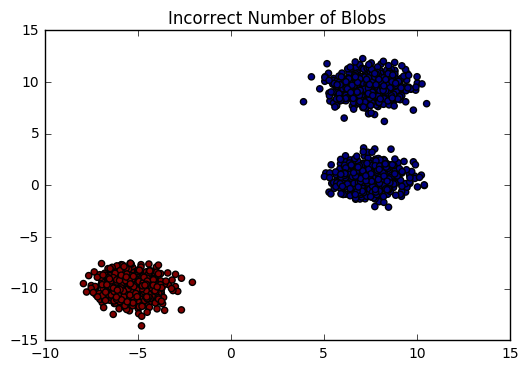

In [4]:
from sklearn.cluster import KMeans
# Incorrect number of clusters
y_pred = KMeans(n_clusters=2).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

The algorithm has put 2 blobs in one class, and the other blob in the second class. Let's try with 3 classes now.

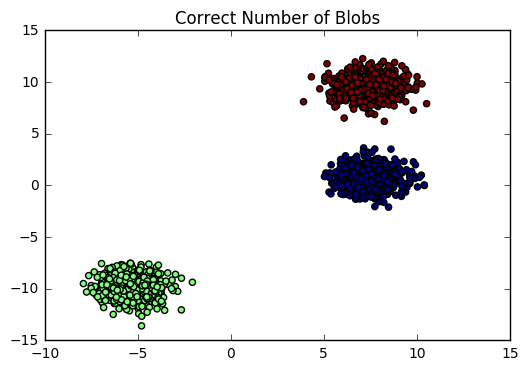

In [5]:
# Correct number of clusters
y_pred = KMeans(n_clusters=3).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Correct Number of Blobs")

This time, the clustering gives the blobs we initially had. The only difference is that the classes (0, 1 and 2), which is normal: We can't expect the algorithm to know the label unless we provide some labelled example beforehand!
Let's now try $k = 4$ to see what happens when there are too many clusters.

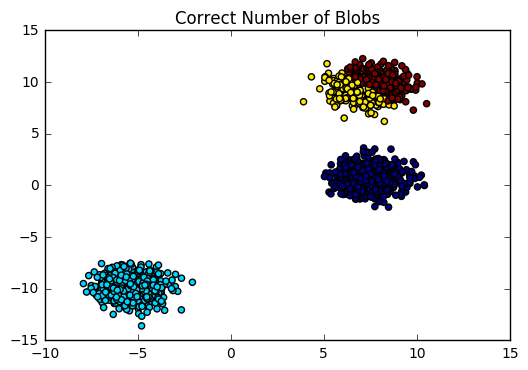

In [6]:
# Incorrect number of clusters
y_pred = KMeans(n_clusters=4).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Correct Number of Blobs")

We see that a blob is split into 2 clusters. Note that the way it is split may vary if we apply the algorithm several times. Try to rerun the above cell several times to verify it. This is due to the randomized initialization (which can be set constant with the `random_state` optional parameter).

Now, let's see another example where the $k$-means algorithm might fail: when the data is anisotropicly distributed. In the previous example, the blobs distributed are *isotrop*, which means uniform in all directions. However, this might not always be the case in real world applications. In the following, we will transform the data so that it's not isotropic anymore.

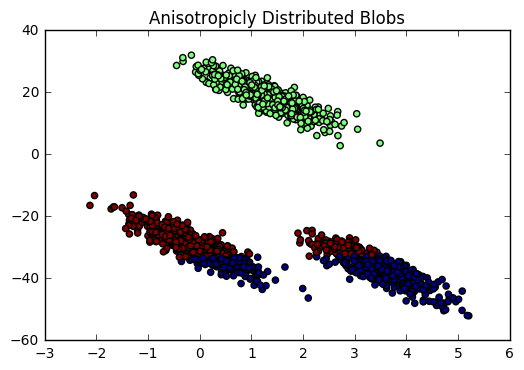

In [7]:
# Anisotropicly distributed data
transformation = [[ 0.5, -5], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3).fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

We can see that 2 of the blobs are not clustered as we would expect. This is normal, the $k$ means algorithm only considers *distances*. This criteria is not well suited in the anisotropic case.

Let's try another case where the k means algorithm behaves well: When the blobs have different variances. This transformation can be done by using the `cluster_std` optional parameter which defines the standard variation of the Gaussian distributions used to generate the blobs.

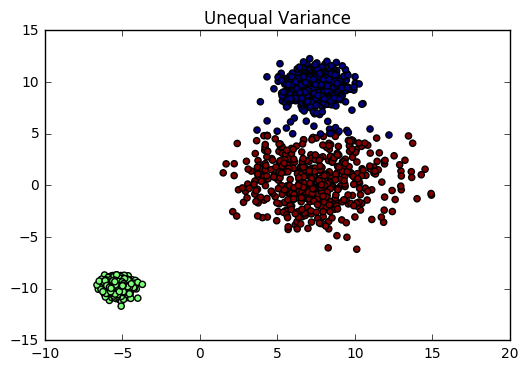

In [8]:
# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

We can see that the blobs are split as we would expect them to be, appart from a few points at the border between 2 blobs when they overlap.

Last case where the $k$-means algorithm behaves well is when the blobs have different densities. In the following example, we will take all the points from the first blob (`y == 0`), 100 from the second one, and only 10 from the last one and run the $k$-means algorithm with this dataset. This operation usually known as *subsampling*.

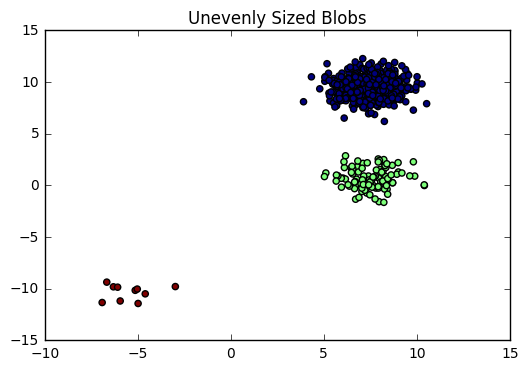

In [9]:
# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_filtered)

plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

We can see that the algorithm has no issue partitionning the data into clusters, that's because subsampling does not affect much the average distance to the centroid.

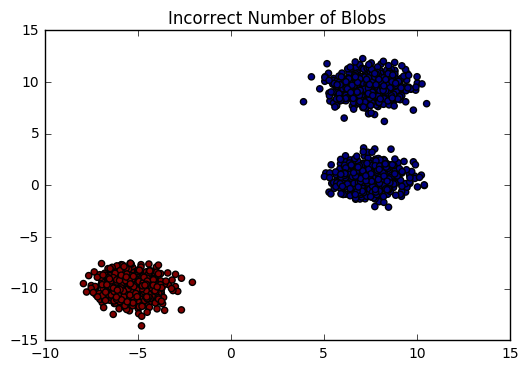

In [10]:
from sklearn.cluster import AgglomerativeClustering

# Incorrect number of clusters
y_pred = AgglomerativeClustering().fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

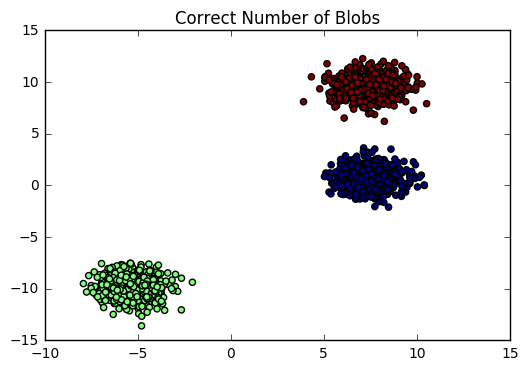

In [11]:
# Correct number of clusters
y_pred = AgglomerativeClustering(n_clusters=3).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Correct Number of Blobs")

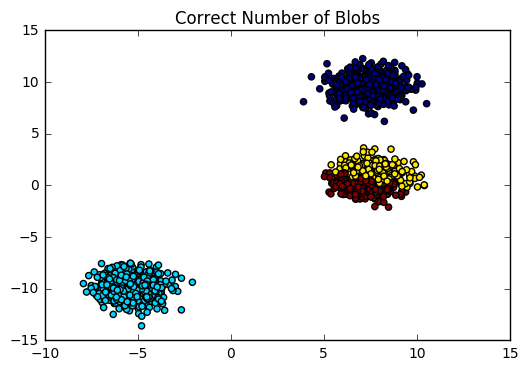

In [12]:
# Incorrect number of clusters
y_pred = AgglomerativeClustering(n_clusters=4).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Correct Number of Blobs")

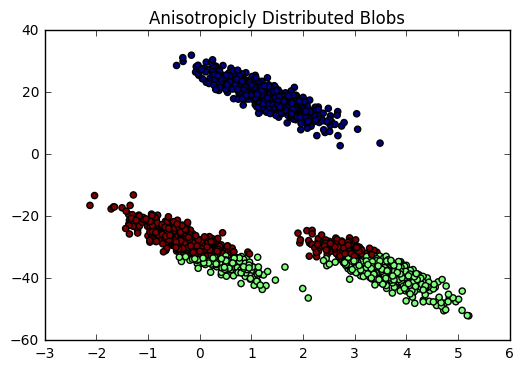

In [13]:
# Anisotropicly distributed data
transformation = [[ 0.5, -5], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
y_pred = AgglomerativeClustering(n_clusters=3).fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

### Applying clustering to images
As we've seen during the course, clustering be used to perform image segmentation. This is the application we are going to work on in this lab.

Let's first load an image. There are images available in `scipy.misc`.

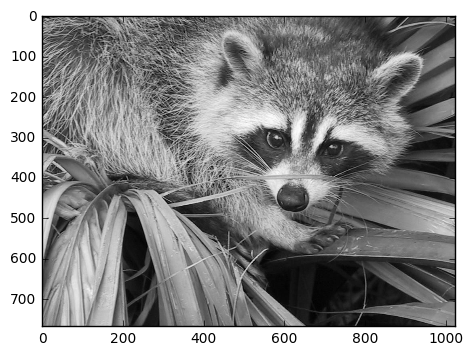

In [44]:
import scipy as sp
face = sp.misc.face(gray=True)
plt.imshow(face, cmap=plt.cm.gray)

The image is simply an array of pixels:

In [45]:
face.shape

(768, 1024)

In image segmentation, we want to split pixels into pixels. For this reason, we have to resize the image so that each point of the dataset corresponds to a pixel.

In [46]:
X = np.reshape(face, (-1, 1))
X.shape

(786432, 1)

Now the data has the proper dimensionality, we can apply a clustering algorithm (such as `KMeans`) to the pixels.

In [49]:
from sklearn.feature_extraction.image import grid_to_graph
n_clusters = 3
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)
label = np.reshape(y_pred, face.shape)

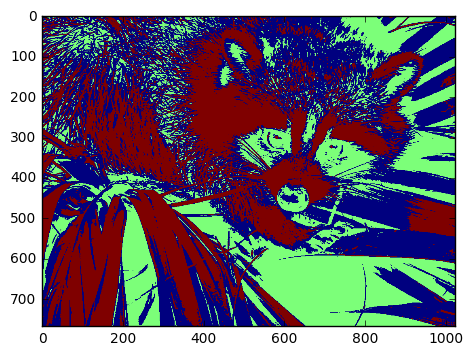

In [50]:
plt.imshow(label)

We can apply the same pipeline to another image:

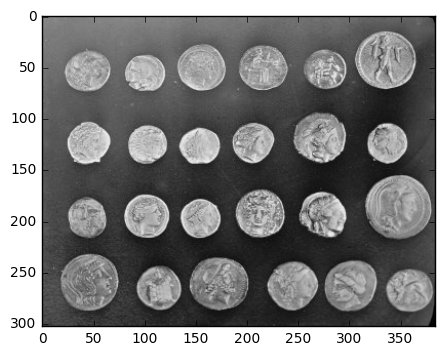

In [51]:
from skimage import data

image = data.coins()
plt.imshow(image, cmap=plt.cm.gray)

In [52]:
X = np.reshape(image, (-1, 1))
n_clusters = 2
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X)
label = np.reshape(y_pred, image.shape)

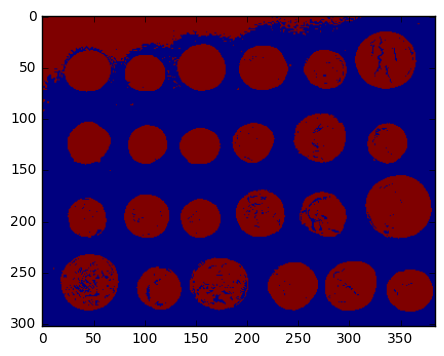

In [53]:
plt.imshow(label)

This is a very basic example, with no processing used whatsoever. It is possible to obtain much better results using some preprocessing, as shown in [this example](http://scikit-learn.org/stable/auto_examples/cluster/plot_face_ward_segmentation.html#sphx-glr-auto-examples-cluster-plot-face-ward-segmentation-py).